In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_A"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)



Classes: ['Batting', 'Bowling', 'Fielding', 'Umpire']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)


Total training images: 11169
Total validation images: 2898
Total test images: 3627
Total images in dataset: 17694


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))


Training images (excluding 'random_occlusion'): 9928
Validation images (excluding 'random_occlusion'): 2576
Test images (excluding 'random_occlusion'): 3224
Total images (excluding 'random_occlusion'): 15728


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'lens_flare', 'low_resolution', 'original', 'blur', 'motion_blur', 'random_occlusion', 'gaussian_noise', 'dirty_lens', 'chromatic_aberration'}
Validation folders considered: {'lens_flare', 'low_resolution', 'original', 'blur', 'motion_blur', 'random_occlusion', 'gaussian_noise', 'dirty_lens', 'chromatic_aberration'}
Test folders considered: {'lens_flare', 'low_resolution', 'original', 'blur', 'motion_blur', 'random_occlusion', 'gaussian_noise', 'dirty_lens', 'chromatic_aberration'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))


Classes: ['Batting', 'Bowling', 'Fielding', 'Umpire']
Final Training images: 9928
Final Validation images: 2576
Final Test images: 3224
Total images after filtering: 15728


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'lens_flare', 'low_resolution', 'original', 'blur', 'motion_blur', 'gaussian_noise', 'dirty_lens', 'chromatic_aberration'}
Validation folders considered: {'lens_flare', 'low_resolution', 'original', 'blur', 'motion_blur', 'gaussian_noise', 'dirty_lens', 'chromatic_aberration'}
Test folders considered: {'lens_flare', 'low_resolution', 'original', 'blur', 'motion_blur', 'gaussian_noise', 'dirty_lens', 'chromatic_aberration'}


In [7]:

def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class ConvBNReLU(nn.Module):
    """Standard convolution block: Conv2d + BatchNorm + ReLU6"""
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1, norm_layer=None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False)
        self.bn = norm_layer(out_planes)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu6(x, inplace=True)

class InvertedResidual(nn.Module):
    """Inverted Residual Block (Mobile Inverted Bottleneck)"""
    def __init__(self, inp, oup, stride, expand_ratio, norm_layer=None):
        super().__init__()
        self.stride = stride
        if stride not in [1, 2]:
            raise ValueError(f"stride should be 1 or 2 instead of {stride}")
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
            
        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup
        
        layers = []
        
        if expand_ratio != 1:
            # Pointwise expansion (1x1 conv)
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer))
        
        layers.extend([
            # Depthwise convolution (3x3 conv with groups)
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim, norm_layer=norm_layer),
            # Pointwise projection (1x1 conv without ReLU)
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        ])
        
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MyMobileNetV2(nn.Module):
    """MobileNetV2 Implementation from Scratch"""
    def __init__(self, num_classes=4, width_mult=1.0, inverted_residual_setting=None, 
                 round_nearest=8, block=None, norm_layer=None):
        super().__init__()
        
        if block is None:
            block = InvertedResidual
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        
        input_channel = 32
        last_channel = 1280
        
        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],   # Stage 1
                [6, 24, 2, 2],   # Stage 2
                [6, 32, 3, 2],   # Stage 3
                [6, 64, 4, 2],   # Stage 4
                [6, 96, 3, 1],   # Stage 5
                [6, 160, 3, 2],  # Stage 6
                [6, 320, 1, 1],  # Stage 7
            ]
        
        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError("inverted_residual_setting should be non-empty "
                           "or a 4-element list, got {}".format(inverted_residual_setting))
        
        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        
        features = [ConvBNReLU(3, input_channel, stride=2, norm_layer=norm_layer)]
        
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer))
                input_channel = output_channel
        
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer))
        
        # make it nn.Sequential
        self.features = nn.Sequential(*features)
        
        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )
        
        # weight initialization
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using appropriate methods"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)
    
    def _forward_impl(self, x):
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1 => must use reshape with x.shape[0]
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def forward(self, x):
        return self._forward_impl(x)




In [8]:
# -----------------------------
# 3. Training Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyMobileNetV2(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("MobileNetV2 Model Summary:")
try:
    summary(model, (3, 224, 224))
except:
    print("Model summary generation failed - this is normal for complex architectures")
    print(f"Model created successfully with {sum(p.numel() for p in model.parameters()):,} parameters")



MobileNetV2 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
        ConvBNReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
        ConvBNReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
       ConvBNReLU-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchN


🚀 Starting MobileNetV2 Training for 50 epochs...

📈 Epoch 1/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [02:28<00:00,  2.09it/s, Loss=1.0386, Acc=0.5881, GPU=0.1GB]


✅ Training completed in 148.60s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:33<00:00,  2.38it/s, Loss=1.1099, Acc=0.5800]


✅ Validation completed in 33.98s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.5800

📊 Epoch 1 Summary:
│ Train Loss: 1.0386 | Train Acc: 0.5881
│ Val Loss:   1.1099 | Val Acc:   0.5800
│ Train Time: 148.60s | Val Time: 33.98s
│ Total Epoch Time: 182.59s
│ Best Val Acc: 0.5800 (Epoch 1)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 2/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.10it/s, Loss=0.7487, Acc=0.7064, GPU=0.1GB]


✅ Training completed in 100.38s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.88it/s, Loss=1.1059, Acc=0.6262]


✅ Validation completed in 20.90s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.6262

📊 Epoch 2 Summary:
│ Train Loss: 0.7487 | Train Acc: 0.7064
│ Val Loss:   1.1059 | Val Acc:   0.6262
│ Train Time: 100.38s | Val Time: 20.90s
│ Total Epoch Time: 121.29s
│ Best Val Acc: 0.6262 (Epoch 2)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 3/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:39<00:00,  3.14it/s, Loss=0.5117, Acc=0.8070, GPU=0.1GB]


✅ Training completed in 99.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.96it/s, Loss=1.1138, Acc=0.6712]


✅ Validation completed in 20.48s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.6712

📊 Epoch 3 Summary:
│ Train Loss: 0.5117 | Train Acc: 0.8070
│ Val Loss:   1.1138 | Val Acc:   0.6712
│ Train Time: 99.18s | Val Time: 20.48s
│ Total Epoch Time: 119.67s
│ Best Val Acc: 0.6712 (Epoch 3)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 4/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.11it/s, Loss=0.3229, Acc=0.8820, GPU=0.1GB]


✅ Training completed in 100.09s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.91it/s, Loss=1.4962, Acc=0.6176]


✅ Validation completed in 20.73s

📊 Epoch 4 Summary:
│ Train Loss: 0.3229 | Train Acc: 0.8820
│ Val Loss:   1.4962 | Val Acc:   0.6176
│ Train Time: 100.09s | Val Time: 20.73s
│ Total Epoch Time: 120.82s
│ Best Val Acc: 0.6712 (Epoch 3)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 5/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.09it/s, Loss=0.1788, Acc=0.9353, GPU=0.1GB]


✅ Training completed in 100.78s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:21<00:00,  3.81it/s, Loss=1.5682, Acc=0.6075]


✅ Validation completed in 21.27s

📊 Epoch 5 Summary:
│ Train Loss: 0.1788 | Train Acc: 0.9353
│ Val Loss:   1.5682 | Val Acc:   0.6075
│ Train Time: 100.78s | Val Time: 21.27s
│ Total Epoch Time: 122.06s
│ Best Val Acc: 0.6712 (Epoch 3)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 6/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:41<00:00,  3.06it/s, Loss=0.1389, Acc=0.9532, GPU=0.1GB]


✅ Training completed in 101.73s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:21<00:00,  3.84it/s, Loss=1.2414, Acc=0.6863]


✅ Validation completed in 21.08s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.6863

📊 Epoch 6 Summary:
│ Train Loss: 0.1389 | Train Acc: 0.9532
│ Val Loss:   1.2414 | Val Acc:   0.6863
│ Train Time: 101.73s | Val Time: 21.08s
│ Total Epoch Time: 122.82s
│ Best Val Acc: 0.6863 (Epoch 6)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 7/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:41<00:00,  3.06it/s, Loss=0.0950, Acc=0.9670, GPU=0.1GB]


✅ Training completed in 101.68s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.87it/s, Loss=1.8176, Acc=0.6762]


✅ Validation completed in 20.94s

📊 Epoch 7 Summary:
│ Train Loss: 0.0950 | Train Acc: 0.9670
│ Val Loss:   1.8176 | Val Acc:   0.6762
│ Train Time: 101.68s | Val Time: 20.94s
│ Total Epoch Time: 122.63s
│ Best Val Acc: 0.6863 (Epoch 6)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 8/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.11it/s, Loss=0.0941, Acc=0.9674, GPU=0.1GB]


✅ Training completed in 100.03s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.95it/s, Loss=1.5530, Acc=0.6937]


✅ Validation completed in 20.51s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.6937

📊 Epoch 8 Summary:
│ Train Loss: 0.0941 | Train Acc: 0.9674
│ Val Loss:   1.5530 | Val Acc:   0.6937
│ Train Time: 100.03s | Val Time: 20.51s
│ Total Epoch Time: 120.54s
│ Best Val Acc: 0.6937 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 9/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.10it/s, Loss=0.0653, Acc=0.9772, GPU=0.1GB]


✅ Training completed in 100.38s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.93it/s, Loss=1.6425, Acc=0.6793]


✅ Validation completed in 20.62s

📊 Epoch 9 Summary:
│ Train Loss: 0.0653 | Train Acc: 0.9772
│ Val Loss:   1.6425 | Val Acc:   0.6793
│ Train Time: 100.38s | Val Time: 20.62s
│ Total Epoch Time: 121.00s
│ Best Val Acc: 0.6937 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 10/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:41<00:00,  3.07it/s, Loss=0.0758, Acc=0.9735, GPU=0.1GB]


✅ Training completed in 101.21s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:21<00:00,  3.85it/s, Loss=1.8232, Acc=0.6479]


✅ Validation completed in 21.06s

📊 Epoch 10 Summary:
│ Train Loss: 0.0758 | Train Acc: 0.9735
│ Val Loss:   1.8232 | Val Acc:   0.6479
│ Train Time: 101.21s | Val Time: 21.06s
│ Total Epoch Time: 122.27s
│ Best Val Acc: 0.6937 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 11/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.09it/s, Loss=0.0617, Acc=0.9771, GPU=0.1GB]


✅ Training completed in 100.80s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.91it/s, Loss=1.7345, Acc=0.6887]


✅ Validation completed in 20.71s

📊 Epoch 11 Summary:
│ Train Loss: 0.0617 | Train Acc: 0.9771
│ Val Loss:   1.7345 | Val Acc:   0.6887
│ Train Time: 100.80s | Val Time: 20.71s
│ Total Epoch Time: 121.51s
│ Best Val Acc: 0.6937 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 12/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.09it/s, Loss=0.0527, Acc=0.9817, GPU=0.1GB]


✅ Training completed in 100.58s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.87it/s, Loss=1.8037, Acc=0.6863]


✅ Validation completed in 20.93s

📊 Epoch 12 Summary:
│ Train Loss: 0.0527 | Train Acc: 0.9817
│ Val Loss:   1.8037 | Val Acc:   0.6863
│ Train Time: 100.58s | Val Time: 20.93s
│ Total Epoch Time: 121.52s
│ Best Val Acc: 0.6937 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 13/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.09it/s, Loss=0.0559, Acc=0.9803, GPU=0.1GB]


✅ Training completed in 100.81s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.88it/s, Loss=1.6890, Acc=0.6782]


✅ Validation completed in 20.90s

📊 Epoch 13 Summary:
│ Train Loss: 0.0559 | Train Acc: 0.9803
│ Val Loss:   1.6890 | Val Acc:   0.6782
│ Train Time: 100.81s | Val Time: 20.90s
│ Total Epoch Time: 121.71s
│ Best Val Acc: 0.6937 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 14/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:41<00:00,  3.07it/s, Loss=0.0505, Acc=0.9824, GPU=0.1GB]


✅ Training completed in 101.16s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.86it/s, Loss=1.8885, Acc=0.6922]


✅ Validation completed in 20.96s

📊 Epoch 14 Summary:
│ Train Loss: 0.0505 | Train Acc: 0.9824
│ Val Loss:   1.8885 | Val Acc:   0.6922
│ Train Time: 101.16s | Val Time: 20.96s
│ Total Epoch Time: 122.12s
│ Best Val Acc: 0.6937 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 15/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.10it/s, Loss=0.0502, Acc=0.9829, GPU=0.1GB]


✅ Training completed in 100.38s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.87it/s, Loss=1.7120, Acc=0.7418]


✅ Validation completed in 20.95s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.7418

📊 Epoch 15 Summary:
│ Train Loss: 0.0502 | Train Acc: 0.9829
│ Val Loss:   1.7120 | Val Acc:   0.7418
│ Train Time: 100.38s | Val Time: 20.95s
│ Total Epoch Time: 121.33s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 16/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.09it/s, Loss=0.0282, Acc=0.9909, GPU=0.1GB]


✅ Training completed in 100.79s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.90it/s, Loss=1.7342, Acc=0.6902]


✅ Validation completed in 20.75s

📊 Epoch 16 Summary:
│ Train Loss: 0.0282 | Train Acc: 0.9909
│ Val Loss:   1.7342 | Val Acc:   0.6902
│ Train Time: 100.79s | Val Time: 20.75s
│ Total Epoch Time: 121.55s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 17/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.10it/s, Loss=0.0582, Acc=0.9797, GPU=0.1GB]


✅ Training completed in 100.48s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.90it/s, Loss=2.1054, Acc=0.6960]


✅ Validation completed in 20.75s

📊 Epoch 17 Summary:
│ Train Loss: 0.0582 | Train Acc: 0.9797
│ Val Loss:   2.1054 | Val Acc:   0.6960
│ Train Time: 100.48s | Val Time: 20.75s
│ Total Epoch Time: 121.24s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 18/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.10it/s, Loss=0.0629, Acc=0.9801, GPU=0.1GB]


✅ Training completed in 100.47s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.90it/s, Loss=1.5920, Acc=0.7244]


✅ Validation completed in 20.75s

📊 Epoch 18 Summary:
│ Train Loss: 0.0629 | Train Acc: 0.9801
│ Val Loss:   1.5920 | Val Acc:   0.7244
│ Train Time: 100.47s | Val Time: 20.75s
│ Total Epoch Time: 121.23s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 19/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.08it/s, Loss=0.0612, Acc=0.9808, GPU=0.1GB]


✅ Training completed in 100.86s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.89it/s, Loss=1.7411, Acc=0.7232]


✅ Validation completed in 20.84s

📊 Epoch 19 Summary:
│ Train Loss: 0.0612 | Train Acc: 0.9808
│ Val Loss:   1.7411 | Val Acc:   0.7232
│ Train Time: 100.86s | Val Time: 20.84s
│ Total Epoch Time: 121.70s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 20/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:41<00:00,  3.07it/s, Loss=0.0295, Acc=0.9910, GPU=0.1GB]


✅ Training completed in 101.25s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:21<00:00,  3.83it/s, Loss=1.7951, Acc=0.7131]


✅ Validation completed in 21.16s

📊 Epoch 20 Summary:
│ Train Loss: 0.0295 | Train Acc: 0.9910
│ Val Loss:   1.7951 | Val Acc:   0.7131
│ Train Time: 101.25s | Val Time: 21.16s
│ Total Epoch Time: 122.41s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 21/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:41<00:00,  3.08it/s, Loss=0.0399, Acc=0.9852, GPU=0.1GB]


✅ Training completed in 101.12s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.89it/s, Loss=1.9055, Acc=0.7015]


✅ Validation completed in 20.83s

📊 Epoch 21 Summary:
│ Train Loss: 0.0399 | Train Acc: 0.9852
│ Val Loss:   1.9055 | Val Acc:   0.7015
│ Train Time: 101.12s | Val Time: 20.83s
│ Total Epoch Time: 121.96s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 22/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:41<00:00,  3.08it/s, Loss=0.0243, Acc=0.9919, GPU=0.1GB]


✅ Training completed in 101.01s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.93it/s, Loss=1.8354, Acc=0.7127]


✅ Validation completed in 20.60s

📊 Epoch 22 Summary:
│ Train Loss: 0.0243 | Train Acc: 0.9919
│ Val Loss:   1.8354 | Val Acc:   0.7127
│ Train Time: 101.01s | Val Time: 20.60s
│ Total Epoch Time: 121.61s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 23/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.10it/s, Loss=0.0230, Acc=0.9918, GPU=0.1GB]


✅ Training completed in 100.47s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.93it/s, Loss=1.8238, Acc=0.7325]


✅ Validation completed in 20.60s

📊 Epoch 23 Summary:
│ Train Loss: 0.0230 | Train Acc: 0.9918
│ Val Loss:   1.8238 | Val Acc:   0.7325
│ Train Time: 100.47s | Val Time: 20.60s
│ Total Epoch Time: 121.08s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 24/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.09it/s, Loss=0.0160, Acc=0.9944, GPU=0.1GB]


✅ Training completed in 100.73s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.92it/s, Loss=1.9773, Acc=0.7193]


✅ Validation completed in 20.64s

📊 Epoch 24 Summary:
│ Train Loss: 0.0160 | Train Acc: 0.9944
│ Val Loss:   1.9773 | Val Acc:   0.7193
│ Train Time: 100.73s | Val Time: 20.64s
│ Total Epoch Time: 121.38s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 25/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.10it/s, Loss=0.0575, Acc=0.9825, GPU=0.1GB]


✅ Training completed in 100.43s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.87it/s, Loss=2.0414, Acc=0.6343]


✅ Validation completed in 20.91s

📊 Epoch 25 Summary:
│ Train Loss: 0.0575 | Train Acc: 0.9825
│ Val Loss:   2.0414 | Val Acc:   0.6343
│ Train Time: 100.43s | Val Time: 20.91s
│ Total Epoch Time: 121.34s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 26/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.10it/s, Loss=0.0481, Acc=0.9833, GPU=0.1GB]


✅ Training completed in 100.27s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.98it/s, Loss=1.8427, Acc=0.7333]


✅ Validation completed in 20.35s

📊 Epoch 26 Summary:
│ Train Loss: 0.0481 | Train Acc: 0.9833
│ Val Loss:   1.8427 | Val Acc:   0.7333
│ Train Time: 100.27s | Val Time: 20.35s
│ Total Epoch Time: 120.62s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 27/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.08it/s, Loss=0.0234, Acc=0.9921, GPU=0.1GB]


✅ Training completed in 100.92s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.98it/s, Loss=1.7199, Acc=0.7271]


✅ Validation completed in 20.37s

📊 Epoch 27 Summary:
│ Train Loss: 0.0234 | Train Acc: 0.9921
│ Val Loss:   1.7199 | Val Acc:   0.7271
│ Train Time: 100.92s | Val Time: 20.37s
│ Total Epoch Time: 121.30s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 28/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.10it/s, Loss=0.0101, Acc=0.9970, GPU=0.1GB]


✅ Training completed in 100.43s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.95it/s, Loss=1.7947, Acc=0.7224]


✅ Validation completed in 20.48s

📊 Epoch 28 Summary:
│ Train Loss: 0.0101 | Train Acc: 0.9970
│ Val Loss:   1.7947 | Val Acc:   0.7224
│ Train Time: 100.43s | Val Time: 20.48s
│ Total Epoch Time: 120.92s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 29/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:39<00:00,  3.11it/s, Loss=0.0170, Acc=0.9953, GPU=0.1GB]


✅ Training completed in 99.91s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.94it/s, Loss=1.9987, Acc=0.7120]


✅ Validation completed in 20.56s

📊 Epoch 29 Summary:
│ Train Loss: 0.0170 | Train Acc: 0.9953
│ Val Loss:   1.9987 | Val Acc:   0.7120
│ Train Time: 99.91s | Val Time: 20.56s
│ Total Epoch Time: 120.48s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 30/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:39<00:00,  3.13it/s, Loss=0.0665, Acc=0.9785, GPU=0.1GB]


✅ Training completed in 99.34s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.97it/s, Loss=1.7581, Acc=0.7418]


✅ Validation completed in 20.39s

📊 Epoch 30 Summary:
│ Train Loss: 0.0665 | Train Acc: 0.9785
│ Val Loss:   1.7581 | Val Acc:   0.7418
│ Train Time: 99.34s | Val Time: 20.39s
│ Total Epoch Time: 119.73s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 31/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:39<00:00,  3.14it/s, Loss=0.0219, Acc=0.9928, GPU=0.1GB]


✅ Training completed in 99.09s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:21<00:00,  3.85it/s, Loss=2.0606, Acc=0.7026]


✅ Validation completed in 21.03s

📊 Epoch 31 Summary:
│ Train Loss: 0.0219 | Train Acc: 0.9928
│ Val Loss:   2.0606 | Val Acc:   0.7026
│ Train Time: 99.09s | Val Time: 21.03s
│ Total Epoch Time: 120.12s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 32/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.11it/s, Loss=0.0094, Acc=0.9971, GPU=0.1GB]


✅ Training completed in 100.02s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:19<00:00,  4.05it/s, Loss=2.0897, Acc=0.7162]


✅ Validation completed in 20.00s

📊 Epoch 32 Summary:
│ Train Loss: 0.0094 | Train Acc: 0.9971
│ Val Loss:   2.0897 | Val Acc:   0.7162
│ Train Time: 100.02s | Val Time: 20.00s
│ Total Epoch Time: 120.02s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 33/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:39<00:00,  3.13it/s, Loss=0.0018, Acc=0.9997, GPU=0.1GB]


✅ Training completed in 99.28s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.91it/s, Loss=2.1799, Acc=0.7023]


✅ Validation completed in 20.71s

📊 Epoch 33 Summary:
│ Train Loss: 0.0018 | Train Acc: 0.9997
│ Val Loss:   2.1799 | Val Acc:   0.7023
│ Train Time: 99.28s | Val Time: 20.71s
│ Total Epoch Time: 119.99s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 34/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.09it/s, Loss=0.0021, Acc=0.9995, GPU=0.1GB]


✅ Training completed in 100.60s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.90it/s, Loss=2.1933, Acc=0.7166]


✅ Validation completed in 20.78s

📊 Epoch 34 Summary:
│ Train Loss: 0.0021 | Train Acc: 0.9995
│ Val Loss:   2.1933 | Val Acc:   0.7166
│ Train Time: 100.60s | Val Time: 20.78s
│ Total Epoch Time: 121.38s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 35/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.09it/s, Loss=0.0505, Acc=0.9856, GPU=0.1GB]


✅ Training completed in 100.60s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:21<00:00,  3.85it/s, Loss=1.9170, Acc=0.6825]


✅ Validation completed in 21.02s

📊 Epoch 35 Summary:
│ Train Loss: 0.0505 | Train Acc: 0.9856
│ Val Loss:   1.9170 | Val Acc:   0.6825
│ Train Time: 100.60s | Val Time: 21.02s
│ Total Epoch Time: 121.62s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 36/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:39<00:00,  3.12it/s, Loss=0.0523, Acc=0.9827, GPU=0.1GB]


✅ Training completed in 99.74s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.94it/s, Loss=1.9911, Acc=0.7116]


✅ Validation completed in 20.57s

📊 Epoch 36 Summary:
│ Train Loss: 0.0523 | Train Acc: 0.9827
│ Val Loss:   1.9911 | Val Acc:   0.7116
│ Train Time: 99.74s | Val Time: 20.57s
│ Total Epoch Time: 120.31s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 37/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:39<00:00,  3.12it/s, Loss=0.0062, Acc=0.9982, GPU=0.1GB]


✅ Training completed in 99.81s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.92it/s, Loss=1.8508, Acc=0.7271]


✅ Validation completed in 20.65s

📊 Epoch 37 Summary:
│ Train Loss: 0.0062 | Train Acc: 0.9982
│ Val Loss:   1.8508 | Val Acc:   0.7271
│ Train Time: 99.81s | Val Time: 20.65s
│ Total Epoch Time: 120.46s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 38/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:41<00:00,  3.08it/s, Loss=0.0036, Acc=0.9987, GPU=0.1GB]


✅ Training completed in 101.07s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.93it/s, Loss=1.9425, Acc=0.6914]


✅ Validation completed in 20.60s

📊 Epoch 38 Summary:
│ Train Loss: 0.0036 | Train Acc: 0.9987
│ Val Loss:   1.9425 | Val Acc:   0.6914
│ Train Time: 101.07s | Val Time: 20.60s
│ Total Epoch Time: 121.67s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 39/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.10it/s, Loss=0.0301, Acc=0.9908, GPU=0.1GB]


✅ Training completed in 100.42s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:21<00:00,  3.85it/s, Loss=2.4375, Acc=0.6832]


✅ Validation completed in 21.02s

📊 Epoch 39 Summary:
│ Train Loss: 0.0301 | Train Acc: 0.9908
│ Val Loss:   2.4375 | Val Acc:   0.6832
│ Train Time: 100.42s | Val Time: 21.02s
│ Total Epoch Time: 121.44s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 40/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:41<00:00,  3.08it/s, Loss=0.0585, Acc=0.9823, GPU=0.1GB]


✅ Training completed in 101.13s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:21<00:00,  3.85it/s, Loss=1.8890, Acc=0.7151]


✅ Validation completed in 21.06s

📊 Epoch 40 Summary:
│ Train Loss: 0.0585 | Train Acc: 0.9823
│ Val Loss:   1.8890 | Val Acc:   0.7151
│ Train Time: 101.13s | Val Time: 21.06s
│ Total Epoch Time: 122.19s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 41/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.08it/s, Loss=0.0171, Acc=0.9939, GPU=0.1GB]


✅ Training completed in 100.88s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:21<00:00,  3.81it/s, Loss=1.9186, Acc=0.7139]


✅ Validation completed in 21.24s

📊 Epoch 41 Summary:
│ Train Loss: 0.0171 | Train Acc: 0.9939
│ Val Loss:   1.9186 | Val Acc:   0.7139
│ Train Time: 100.88s | Val Time: 21.24s
│ Total Epoch Time: 122.11s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 42/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:41<00:00,  3.07it/s, Loss=0.0073, Acc=0.9974, GPU=0.1GB]


✅ Training completed in 101.31s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:21<00:00,  3.77it/s, Loss=2.0144, Acc=0.6984]


✅ Validation completed in 21.52s

📊 Epoch 42 Summary:
│ Train Loss: 0.0073 | Train Acc: 0.9974
│ Val Loss:   2.0144 | Val Acc:   0.6984
│ Train Time: 101.31s | Val Time: 21.52s
│ Total Epoch Time: 122.83s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 43/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:41<00:00,  3.07it/s, Loss=0.0067, Acc=0.9973, GPU=0.1GB]


✅ Training completed in 101.22s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:21<00:00,  3.84it/s, Loss=2.2091, Acc=0.7120]


✅ Validation completed in 21.09s

📊 Epoch 43 Summary:
│ Train Loss: 0.0067 | Train Acc: 0.9973
│ Val Loss:   2.2091 | Val Acc:   0.7120
│ Train Time: 101.22s | Val Time: 21.09s
│ Total Epoch Time: 122.31s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 44/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:41<00:00,  3.05it/s, Loss=0.0340, Acc=0.9890, GPU=0.1GB]


✅ Training completed in 101.93s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:21<00:00,  3.82it/s, Loss=1.8765, Acc=0.6887]


✅ Validation completed in 21.20s

📊 Epoch 44 Summary:
│ Train Loss: 0.0340 | Train Acc: 0.9890
│ Val Loss:   1.8765 | Val Acc:   0.6887
│ Train Time: 101.93s | Val Time: 21.20s
│ Total Epoch Time: 123.13s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 45/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:41<00:00,  3.06it/s, Loss=0.0131, Acc=0.9959, GPU=0.1GB]


✅ Training completed in 101.76s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:21<00:00,  3.81it/s, Loss=2.0072, Acc=0.7011]


✅ Validation completed in 21.26s

📊 Epoch 45 Summary:
│ Train Loss: 0.0131 | Train Acc: 0.9959
│ Val Loss:   2.0072 | Val Acc:   0.7011
│ Train Time: 101.76s | Val Time: 21.26s
│ Total Epoch Time: 123.02s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 46/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.08it/s, Loss=0.0149, Acc=0.9953, GPU=0.1GB]


✅ Training completed in 100.96s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.91it/s, Loss=2.0937, Acc=0.6941]


✅ Validation completed in 20.73s

📊 Epoch 46 Summary:
│ Train Loss: 0.0149 | Train Acc: 0.9953
│ Val Loss:   2.0937 | Val Acc:   0.6941
│ Train Time: 100.96s | Val Time: 20.73s
│ Total Epoch Time: 121.70s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 47/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.10it/s, Loss=0.0338, Acc=0.9884, GPU=0.1GB]


✅ Training completed in 100.43s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.89it/s, Loss=2.2359, Acc=0.6696]


✅ Validation completed in 20.84s

📊 Epoch 47 Summary:
│ Train Loss: 0.0338 | Train Acc: 0.9884
│ Val Loss:   2.2359 | Val Acc:   0.6696
│ Train Time: 100.43s | Val Time: 20.84s
│ Total Epoch Time: 121.27s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 48/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:41<00:00,  3.08it/s, Loss=0.0174, Acc=0.9947, GPU=0.1GB]


✅ Training completed in 101.07s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:21<00:00,  3.83it/s, Loss=2.1623, Acc=0.7023]


✅ Validation completed in 21.15s

📊 Epoch 48 Summary:
│ Train Loss: 0.0174 | Train Acc: 0.9947
│ Val Loss:   2.1623 | Val Acc:   0.7023
│ Train Time: 101.07s | Val Time: 21.15s
│ Total Epoch Time: 122.22s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 49/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.09it/s, Loss=0.0133, Acc=0.9955, GPU=0.1GB]


✅ Training completed in 100.52s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:20<00:00,  3.91it/s, Loss=2.1582, Acc=0.7123]


✅ Validation completed in 20.72s

📊 Epoch 49 Summary:
│ Train Loss: 0.0133 | Train Acc: 0.9955
│ Val Loss:   2.1582 | Val Acc:   0.7123
│ Train Time: 100.52s | Val Time: 20.72s
│ Total Epoch Time: 121.25s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 50/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 311/311 [01:40<00:00,  3.09it/s, Loss=0.0127, Acc=0.9957, GPU=0.1GB]


✅ Training completed in 100.71s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 81/81 [00:21<00:00,  3.80it/s, Loss=2.1754, Acc=0.7116]


✅ Validation completed in 21.31s

📊 Epoch 50 Summary:
│ Train Loss: 0.0127 | Train Acc: 0.9957
│ Val Loss:   2.1754 | Val Acc:   0.7116
│ Train Time: 100.71s | Val Time: 21.31s
│ Total Epoch Time: 122.03s
│ Best Val Acc: 0.7418 (Epoch 15)
│ GPU Memory: 0.1GB / 2.8GB

💾 Best MobileNetV2 model saved as 'best_mobilenetv2_model.pth'
📊 Best model stats:
│ Best Epoch: 15
│ Best Val Acc: 0.7418

💾 MobileNetV2 training history saved to 'mobilenetv2_training_history.csv'

🎉 MobileNetV2 Training Complete!
Total Training Time: 6133.52s (102.2 minutes)
Average Epoch Time: 122.67s

⏱️  Epoch Timing Breakdown:
│ Epoch 1: 182.59s
│ Epoch 2: 121.29s
│ Epoch 3: 119.67s
│ Epoch 4: 120.82s
│ Epoch 5: 122.06s
│ Epoch 6: 122.82s
│ Epoch 7: 122.63s
│ Epoch 8: 120.54s
│ Epoch 9: 121.00s
│ Epoch 10: 122.27s
│ Epoch 11: 121.51s
│ Epoch 12: 121.52s
│ Epoch 13: 121.71s
│ Epoch 14: 122.12s
│ Epoch 15: 121.33s
│ Epoch 16: 121.55s
│ Epoch 17: 121.24s
│ Epoch 18: 121.23s
│ Epoch 19: 121.70s
│ Epoch 20: 122.41s
│ Epo

Testing MobileNetV2: 100%|██████████████████████████████| 101/101 [00:47<00:00,  2.12it/s]


✅ MobileNetV2 Testing completed in 47.57s

📋 MobileNetV2 Classification Report:
              precision    recall  f1-score   support

     Batting       0.72      0.85      0.78      1656
     Bowling       0.52      0.31      0.39       488
    Fielding       0.59      0.53      0.56       560
      Umpire       0.84      0.75      0.79       520

    accuracy                           0.70      3224
   macro avg       0.67      0.61      0.63      3224
weighted avg       0.68      0.70      0.68      3224

🎯 MobileNetV2 Test Accuracy: 0.6973

📊 MobileNetV2 Model Performance Summary:
│ Best Validation Acc:  0.7418 (Epoch 15)
│ Final Test Accuracy:  0.6973
│ Val-Test Gap:         0.0446


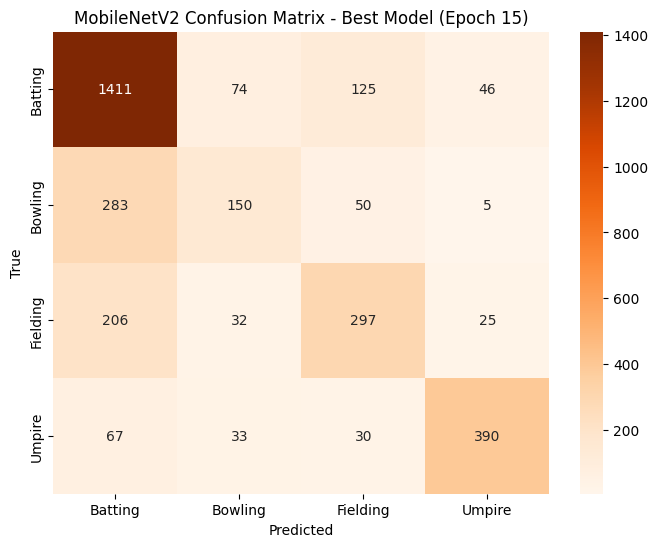

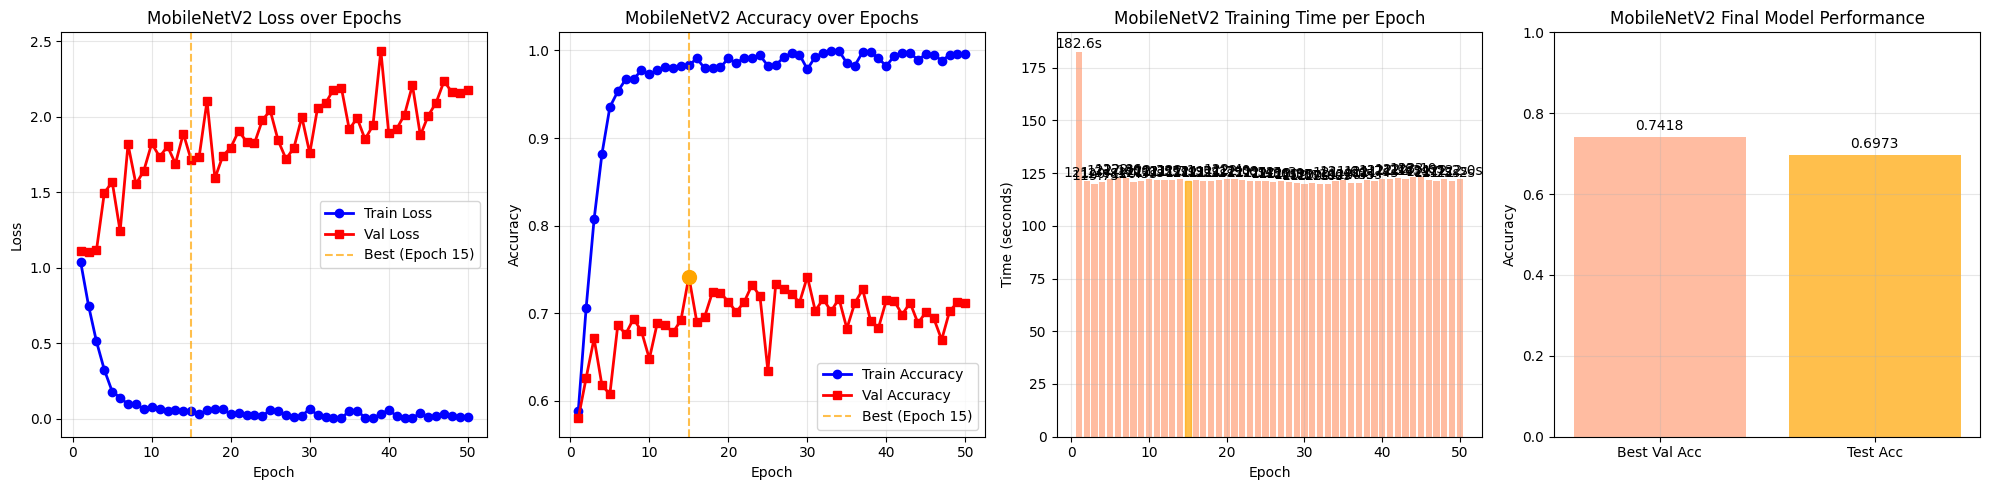


⏰ MobileNetV2 Final Timing Summary:
│ Total Training: 6133.52s
│ Average per Epoch: 122.67s
│ Testing Time: 47.57s
│ Total Runtime: 6181.09s

💾 MobileNetV2 Files saved:
│ best_mobilenetv2_model.pth - Best validation accuracy model
│ mobilenetv2_training_history.csv - Training metrics for later plotting

🏗️  MobileNetV2 Architecture Summary:
│ Total Parameters: 2,228,996
│ Trainable Parameters: 2,228,996
│ Model Size: 8.50 MB
│ Input Size: 224x224x3
│ Output Classes: 4
│ Width Multiplier: 1.0
│ Inverted Residual Blocks: 17
│ Depthwise Separable Convs: Yes
│ ReLU6 Activation: Yes


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
from tqdm import tqdm
import time
# -----------------------------
# 4. Training Loop with Best Model Saving (Val Accuracy) - MobileNetV2
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking
best_val_acc = 0.0
best_model_state = None
best_epoch = 0

print(f"\n🚀 Starting MobileNetV2 Training for {epochs} epochs...")
print("=" * 80)

total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc=f"Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc=f"Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model so far based on val_acc
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best MobileNetV2 model found! Validation Accuracy: {val_acc:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_mobilenetv2_model.pth')
    print(f"\n💾 Best MobileNetV2 model saved as 'best_mobilenetv2_model.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")

# Save training history data to CSV
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}
history_df = pd.DataFrame(history_data)
history_df.to_csv('mobilenetv2_training_history.csv', index=False)
print("\n💾 MobileNetV2 training history saved to 'mobilenetv2_training_history.csv'")

# Training Summary
print(f"\n🎉 MobileNetV2 Training Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")
print("\n⏱️  Epoch Timing Breakdown:")
for i, t in enumerate(epoch_times):
    print(f"│ Epoch {i+1}: {t:.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best MobileNetV2 Model for Testing...")

# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best MobileNetV2 model from epoch {best_epoch} loaded successfully!")
else:
    print("⚠️  No best model found, using current model state")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()

test_pbar = tqdm(test_loader, desc="Testing MobileNetV2", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ MobileNetV2 Testing completed in {test_time:.2f}s")
print("\n📋 MobileNetV2 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"🎯 MobileNetV2 Test Accuracy: {test_accuracy:.4f}")

# Model Performance Summary
print(f"\n📊 MobileNetV2 Model Performance Summary:")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"MobileNetV2 Confusion Matrix - Best Model (Epoch {best_epoch})")
plt.show()

# -----------------------------
# 6. Enhanced Visualizations
# -----------------------------
plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 4, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='orange', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.legend()
plt.title("MobileNetV2 Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 4, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='orange', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='orange', s=100, zorder=5)
plt.legend()
plt.title("MobileNetV2 Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Timing Plot
plt.subplot(1, 4, 3)
bars = plt.bar(range(1, epochs+1), epoch_times, color='lightsalmon', alpha=0.7)
bars[best_epoch-1].set_color('orange')
plt.title("MobileNetV2 Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)
for i, t in enumerate(epoch_times):
    plt.text(i+1, t+0.5, f'{t:.1f}s', ha='center', va='bottom')

# Performance Comparison
plt.subplot(1, 4, 4)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['lightsalmon', 'orange']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("MobileNetV2 Final Model Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n⏰ MobileNetV2 Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

print(f"\n💾 MobileNetV2 Files saved:")
print(f"│ best_mobilenetv2_model.pth - Best validation accuracy model")
print(f"│ mobilenetv2_training_history.csv - Training metrics for later plotting")

# -----------------------------
# 7. MobileNetV2 Architecture Summary
# -----------------------------
print(f"\n🏗️  MobileNetV2 Architecture Summary:")
print(f"│ Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"│ Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"│ Model Size: {sum(p.numel() * p.element_size() for p in model.parameters()) / 1024**2:.2f} MB")
print(f"│ Input Size: 224x224x3")
print(f"│ Output Classes: {len(classes)}")
print(f"│ Width Multiplier: 1.0")
print(f"│ Inverted Residual Blocks: 17")
print(f"│ Depthwise Separable Convs: Yes")
print(f"│ ReLU6 Activation: Yes")